### Importing Libraries

In [113]:
from bs4 import BeautifulSoup
import pandas as pd
import lxml
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

### Getting data from url

In [114]:
url = 'https://en.wikipedia.org/wiki/List_of_largest_companies_by_revenue'
content = requests.get(url).text
soup = BeautifulSoup(content,'lxml')
table_content = soup.find('table', class_ = "wikitable")
table_content

<table class="wikitable sortable sticky-header-multi sort-under" style="text-align:left;">
<tbody><tr>
<th rowspan="2" scope="col">Rank
</th>
<th rowspan="2" scope="col">Name
</th>
<th rowspan="2" scope="col">Industry
</th>
<th scope="col">Revenue
</th>
<th scope="col">Profit
</th>
<th rowspan="2" scope="col">Employees
</th>
<th rowspan="2" scope="col">Headquarters<sup class="reference" id="cite_ref-4"><a href="#cite_note-4"><span class="cite-bracket">[</span>note 1<span class="cite-bracket">]</span></a></sup>
</th>
<th rowspan="2" scope="col"><a href="/wiki/State-owned_enterprise" title="State-owned enterprise">State-owned</a>
</th>
<th class="unsortable" rowspan="2" scope="col"><abbr title="Reference(s)">Ref.</abbr>
</th></tr>
<tr>
<th colspan="2" scope="col"><small>USD millions</small>
</th></tr>
<tr>
<th scope="col">1
</th>
<td><a href="/wiki/Walmart" title="Walmart">Walmart</a></td>
<td><a href="/wiki/Retail" title="Retail">Retail</a></td>
<td style="text-align:center;"><span type

### Creating a table

In [115]:
# table_body
table_body = table_content.find('tbody')

# table_header
table_rows = table_body.find_all('tr')
table_header = table_rows[0]

# header names
header_name = []
table_head = table_header.find_all('th')
for head in table_head:
    header_name.append(head.text.strip().split('[')[0])
header_name

['Rank',
 'Name',
 'Industry',
 'Revenue',
 'Profit',
 'Employees',
 'Headquarters',
 'State-owned',
 'Ref.']

### Creating a dataframe using Pandas

In [116]:
final_data = []
for rows in table_rows[2:]:
    rows_name = []
    rank = rows.find_all('th')
    for data in rank:
        rows_name.append(data.text.strip())
    rest_data = rows.find_all('td')
    for data2 in rest_data:
        rows_name.append(data2.text.strip())
        
    final_data.append(dict(zip(header_name,rows_name)))

companies_df = pd.DataFrame(final_data)
companies_df.head()

,Rank,Name,Industry,Revenue,Profit,Employees,Headquarters,State-owned,Ref.
0,1,Walmart,Retail,"$648,125","$15,511","2,100,000",United States,,[1]
1,2,Amazon,Retail,"$574,785","$30,425","1,525,000",United States,,[4]
2,3,State Grid Corporation of China,Electricity,"$545,948","$9,204","1,361,423",China,,[5]
3,4,Saudi Aramco,Oil and gas,"$494,890","$129,699","73,311",Saudi Arabia,,[6]
4,5,China Petrochemical Corporation,Oil and gas,"$429,700","$9,393","513,434",China,,[7]


In [117]:
# modifying column names
companies_df.columns = [col_names.lower().replace(' ','_').replace('-','_') for col_names in companies_df.columns]

# filling in the column 'state_owned'
state_owned = []
for rows in table_rows[2:]:
    row = rows.find_all('td', class_ = 'table-yes2')
    if row:
        companies_df['state_owned'] = 'Yes'
    else:
        companies_df['state_owned'] = 'No'


In [118]:
companies_df.head()
companies_df.dtypes

rank            object
name            object
industry        object
revenue         object
profit          object
employees       object
headquarters    object
state_owned     object
ref.            object
dtype: object

### Manipulating data

In [119]:
# since we do not need ref. column for our analysis, we can drop it
companies_df.drop(columns = 'ref.', inplace = True)

# we can convert the data types from object to int or float for numeric columns
companies_df['employees'] = \
companies_df['employees'].apply(lambda num: int(num.replace(',','').replace('$','')))

companies_df['revenue'] = \
companies_df['revenue'].apply(lambda num: int(num.replace(',','').replace('$','')))

companies_df['profit'] = \
companies_df['profit'].apply(lambda num: int(num.replace(',','').replace('$','')))

In [120]:
print(companies_df.dtypes)
companies_df.head()

rank            object
name            object
industry        object
revenue          int64
profit           int64
employees        int64
headquarters    object
state_owned     object
dtype: object


,rank,name,industry,revenue,profit,employees,headquarters,state_owned
0,1,Walmart,Retail,648125,15511,2100000,United States,No
1,2,Amazon,Retail,574785,30425,1525000,United States,No
2,3,State Grid Corporation of China,Electricity,545948,9204,1361423,China,No
3,4,Saudi Aramco,Oil and gas,494890,129699,73311,Saudi Arabia,No
4,5,China Petrochemical Corporation,Oil and gas,429700,9393,513434,China,No


In [121]:
companies_df.describe()

,revenue,profit,employees
count,50.000000,50.000000,5.000000e+01
mean,270794.460000,24210.160000,3.365283e+05
std,121085.238208,28237.204142,3.992769e+05
min,153999.000000,261.000000,1.560000e+03
25%,177390.750000,6063.250000,1.026842e+05
50%,218387.000000,15328.000000,2.329625e+05
75%,339232.250000,29447.500000,3.823688e+05
max,648125.000000,129699.000000,2.100000e+06


### Visualizing data

In [129]:
# total sum of revenue and profits based on the type of industry
company_by_industry = companies_df[['industry','revenue','profit']].groupby('industry').sum()
company_by_industry = company_by_industry.reset_index()

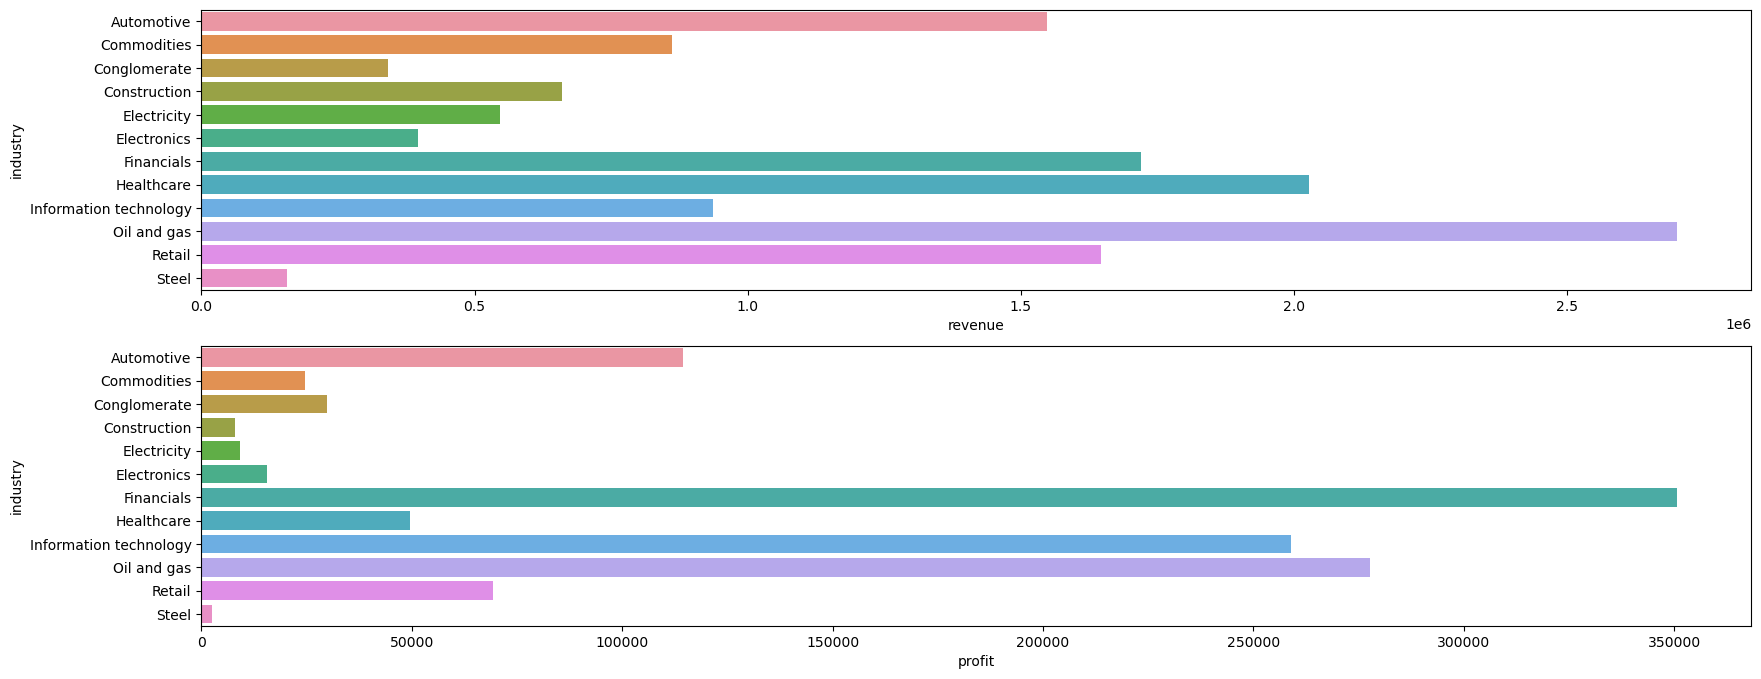

In [138]:
# visualizing revenue and profits made by each industry type
plt.figure(figsize = (20,8))   
plt.subplot(2,1,1)
sns.barplot(x = 'revenue', y = 'industry', data = company_by_industry)

plt.subplot(2,1,2)
sns.barplot(x = 'profit', y = 'industry', data = company_by_industry);

In [141]:
# from the above data we can interpret that even if maximum revugue is generated by 'Oil and Gas'
# the maximum progit i generated by 'Financials'
# similaryly, we can analyse this data using different aspects